# Matching Census Tracts & Community Areas

In order to use Community Areas as the building blocks of Aldermanic Wards, I must first calculate the population of each area.

The [UChicago Library](https://www.lib.uchicago.edu/e/collections/maps/censusinfo.html) has a nice description of Community Areas:
> Community areas, of which there are 77 in Chicago, are supposed to be homogeneous neighborhood-like districts. Many, but not all, do in fact correspond quite closely to neighborhoods that would be recognized by their residents; examples of these are Hyde Park and Uptown. Community areas are peculiar to Chicago. They were apparently first proposed by members of the Social Science Research Committee at the University of Chicago during the 1920s. They have been used ever since by the city government as statistical units. They have the virtue of consistency; except for the addition of O'Hare and the splitting of Edgewater from Uptown, they have remained unchanged since their inception. The U.S. Census Bureau does not compile data for community areas. Although most community area boundaries are coincident with census tract boundaries, because the city limits intersect census tract boundaries in several places, it is not possible to derive community area data from census tract data in a straightforward way.

They say that mapping Community Areas to Census Tracts is not straightforward. Let's check that out!

### Imports & Options

In [1]:
%load_ext autoreload
%autoreload 2

In [186]:
import pandas as pd
import geopandas as gpd
from shapely import MultiPolygon
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import sys
sys.path.append("../src")

In [4]:
from colors import COLORS

In [5]:
# This is to suppress the CRS warning, which I'm aware of.
import warnings
warnings.filterwarnings("ignore")

In [122]:
pd.set_option('display.max_columns', None)

### Data

In [6]:
filepath = "../data/Boundaries - Community Areas (current).geojson"
CAs = gpd.read_file(filepath)

In [7]:
filepath = "../data/2020-census/tl_2020_17_tract/tl_2020_17_tract.shp"
tracts = gpd.read_file(filepath)

In [8]:
filepath = "../data/Boundaries - City.geojson"
city = gpd.read_file(filepath)

### Inspecting Geometries
Do the census tracts sufficiently align with community areas?

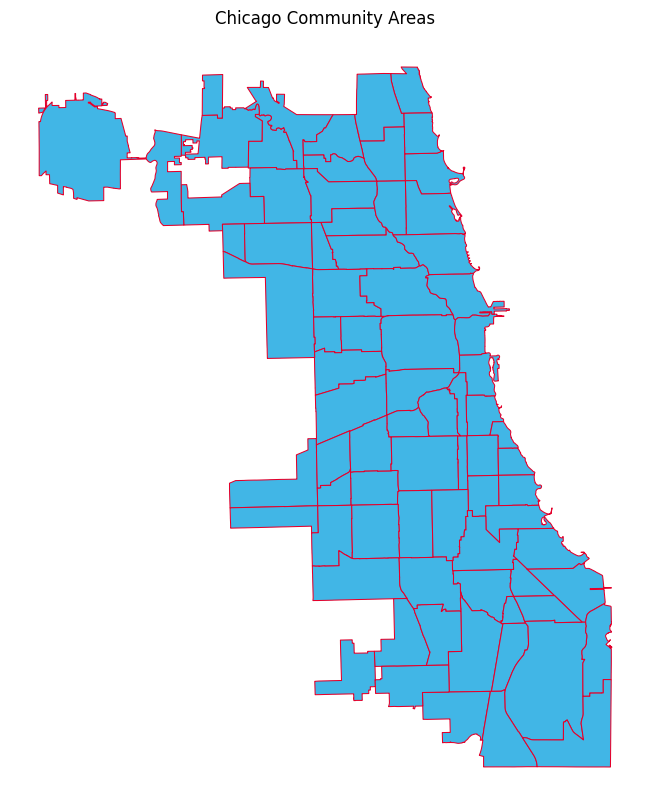

In [9]:
kwargs = {
    "edgecolor": COLORS["red"],
    "color": COLORS["blue"],
    "linewidth": 0.75,
}
ax = CAs.geometry.plot(figsize=(10,10), **kwargs)
ax.set_title("Chicago Community Areas")
ax.set_axis_off()

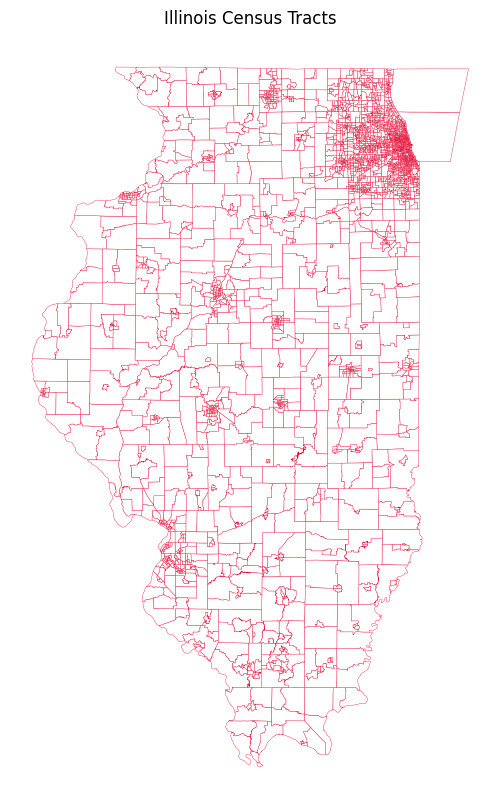

In [10]:
kwargs = {
    "edgecolor": COLORS["red"],
    "color": "#FFFFFF",
    "linewidth": 0.25,
}
ax = tracts.geometry.plot(figsize=(10,10), **kwargs)
ax.set_title("Illinois Census Tracts")
ax.set_axis_off()

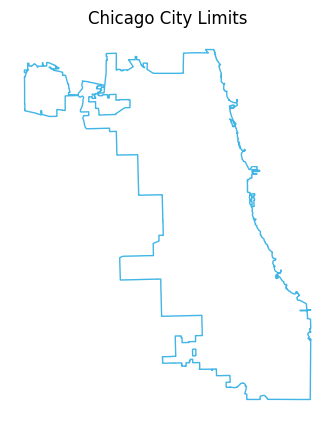

In [11]:
kwargs = {
    "edgecolor": COLORS["blue"],
    "color": "#FFFFFF",
}
ax = city.geometry.plot(figsize=(5,5), **kwargs)
ax.set_title("Chicago City Limits")
ax.set_axis_off()

## Identify Tracts within Chicago
To inspect tracts along city limits, let's bubble out around the city a bit.

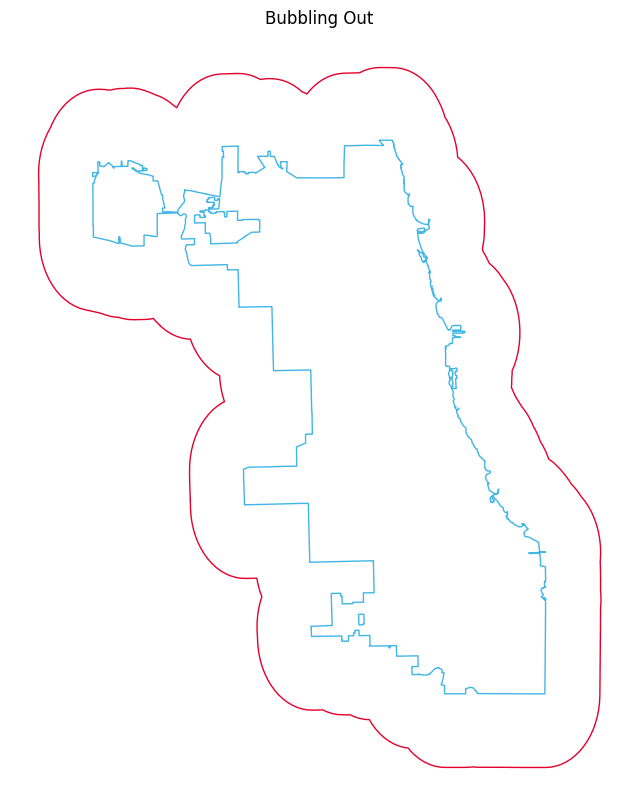

In [12]:
kwargs = {
    "edgecolor": COLORS["red"],
    "color": "#FFFFFF",
}
buffer_dist = 0.05
ax = city.geometry.buffer(buffer_dist).plot(figsize=(10,10), **kwargs)

kwargs = {
    "edgecolor": COLORS["blue"],
    "color": "#FFFFFF",
}
city.geometry.plot(ax=ax, **kwargs)

ax.set_title("Bubbling Out")
ax.set_axis_off()

#### Tracts within the Chicago "Bubble"

In [21]:
filepath = "bubble_census_tracts.pkl"

# buffer_dist = 0.05
# bubble_mask = tracts.geometry.to_crs(city.geometry.crs).apply(lambda gmtry: city.geometry.buffer(buffer_dist).contains(gmtry)).values
# bubble_census_tracts = tracts[bubble_mask]
# bubble_census_tracts.to_pickle(filepath)

bubble_census_tracts = pd.read_pickle(filepath)
bubble_census_tracts.shape[0]

1008

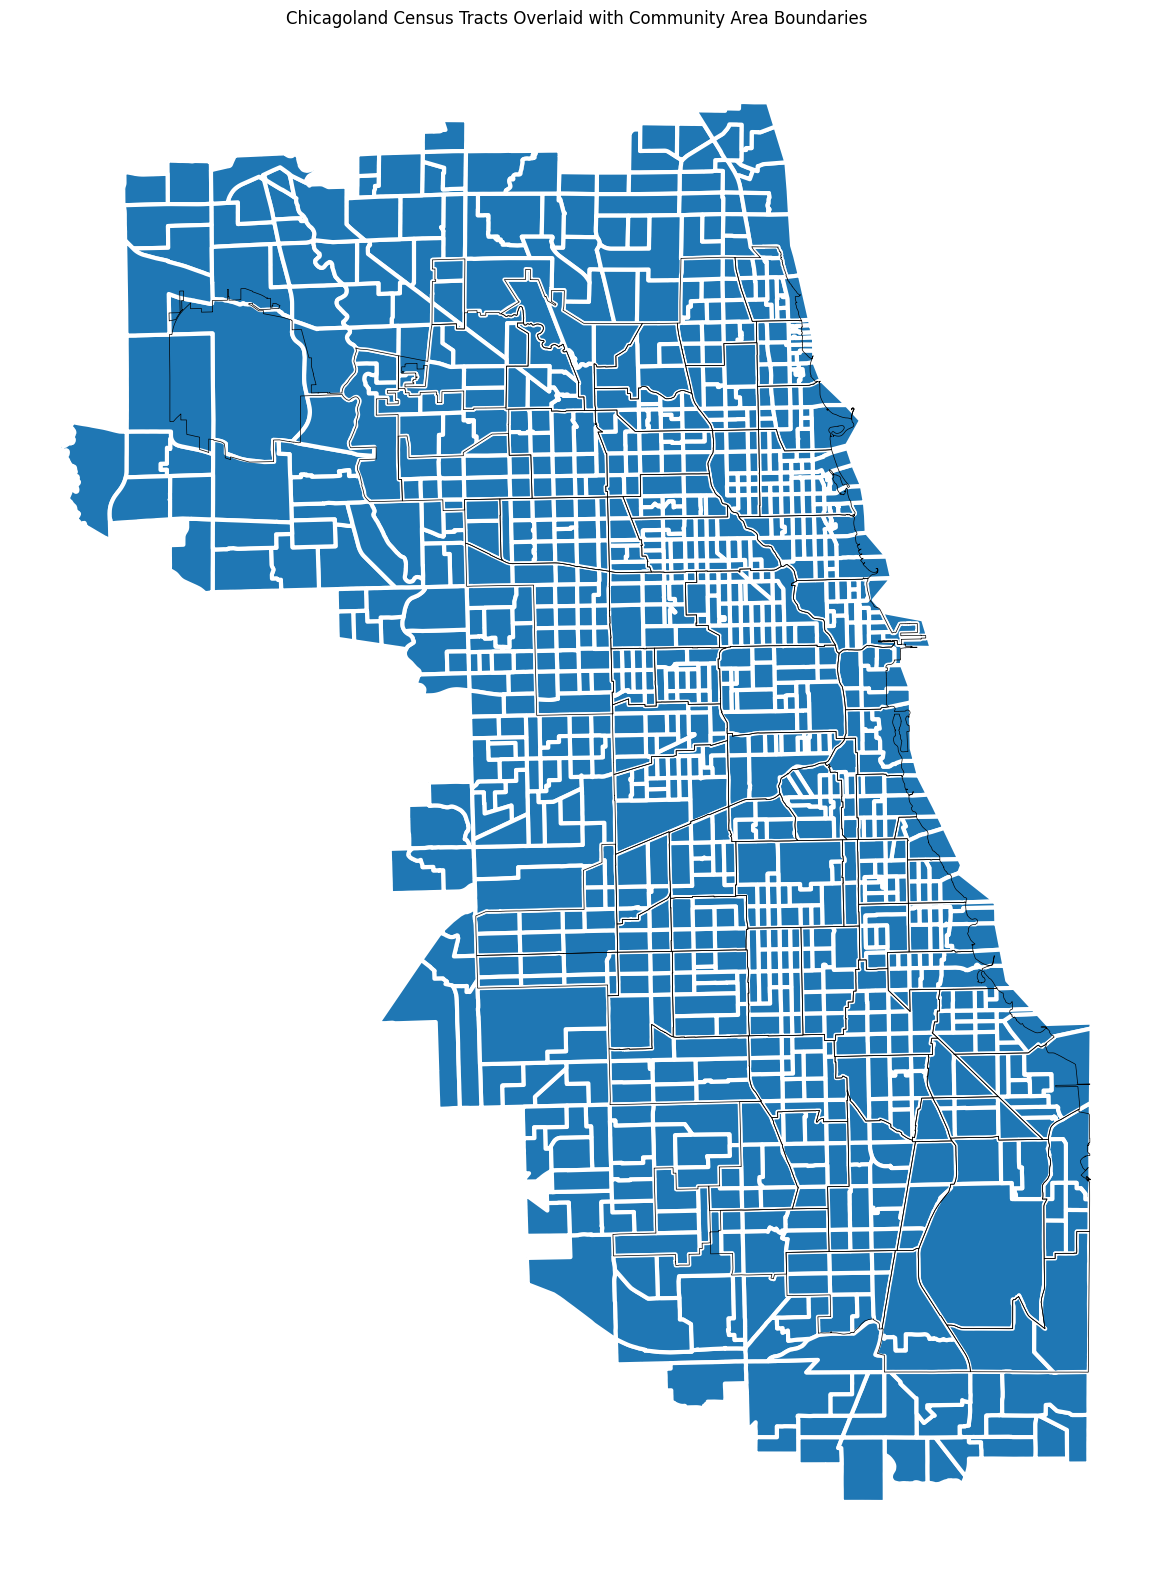

In [22]:
kwargs = {
    "edgecolor": "#FFFFFF",
    "linewidth": 3,
}
ax = bubble_census_tracts.geometry.plot(figsize=(20,20), **kwargs)

kwargs = {
    "edgecolor": "black",
    "color": (0,0,0,0), #transparent
    "linewidth": 0.5,
}
CAs.geometry.plot(ax=ax, **kwargs)

ax.set_title("Chicagoland Census Tracts Overlaid with Community Area Boundaries")
ax.set_axis_off()
# plt.savefig("../plots/tracts_and_community_areas.png", dpi=300)

#### Inspecting Tracts that don't play nice
It appears that most tracts nicely align with the borders of Community Areas. I've manually identified four that do not, but they are tracts that I expect will have no population. They are:  
- O'Hare Airport
- Midway Airport
- A stretch of the Kennedy Expressway 
- A cemetary (but they vote in Chicago!)

I'll confirm their populations in another notebook.

### Assigning Tracts to Community Areas based on Percent Overlap
Calcualte a pairwise matrix of the percent of a census tract surface area that is within each community area. I will assign each tract to the community area that it is most in. This should properly account for census tracts that span into the lake. The community area boundaries hug the shoreline, so shoreline tracts should only overlap with one community area.

In [100]:
# Area of Intersection / Total Tract Area = Percent Tract Overlap
pairwise_overlap = bubble_census_tracts.geometry.apply(lambda gmtry: CAs.geometry.intersection(gmtry).area/gmtry.area)

# Drop Tracts that don't overlap any Community Areas
pairwise_overlap = pairwise_overlap[pairwise_overlap.any(axis=1)]

# Filter by minimum overlap (to exclude those on the opposite side of the border)
threshold = 0.20
pairwise_overlap = pairwise_overlap[pairwise_overlap.max(axis=1) >= threshold]

# CAs are Column Labels; Tracts are Row Labels
pairwise_overlap

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000032,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [101]:
ward_assignments = pd.DataFrame(pairwise_overlap.T.idxmax(), columns=["Ward"])
ward_assignments.index.name = "Tract"
ward_assignments

,Ward
Tract,
0,49
1,50
5,43
6,57
14,9
...,...
3207,54
3208,69
3211,53


### Visualize
The tract off the west side of O'Hare appears to be the only tract I haven't been able to filter out programmatically without removing valid tracts. All the tracts left map cleanly to Community Areas. Borders that don't appear to parks, waterways, or airports.

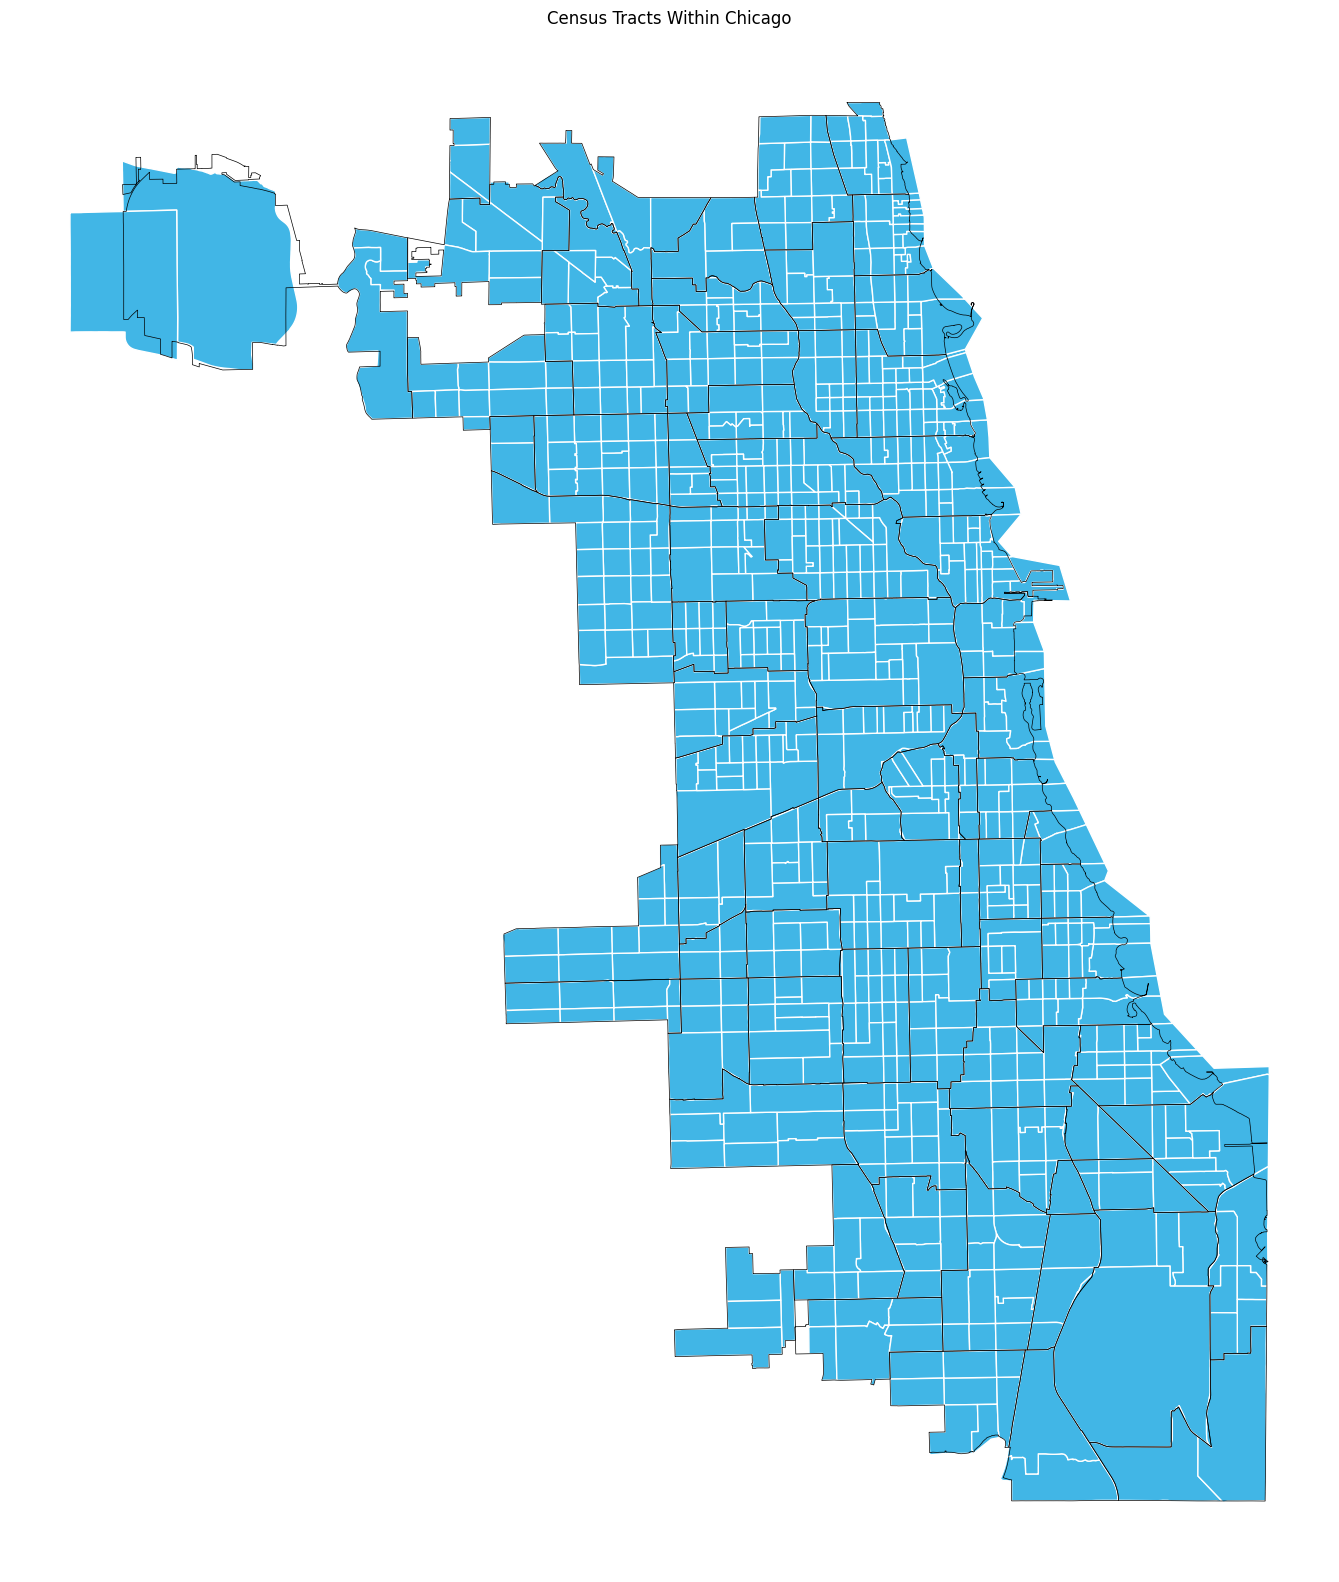

In [192]:
kwargs = {
    "edgecolor": "#FFFFFF",
    "linewidth": 1,
    "color": COLORS["blue"]
}
chicago_tracts = bubble_census_tracts[bubble_census_tracts.index.isin(ward_assignments.index)]
ax = chicago_tracts.geometry.plot(figsize=(20,20), **kwargs)

kwargs = {
    "edgecolor": "black",
    "color": (0,0,0,0), #transparent
    "linewidth": 0.5,
}
CAs.geometry.plot(ax=ax, **kwargs)

ax.set_title("Census Tracts Within Chicago")
ax.set_axis_off()
# plt.savefig("../plots/census_tracts_within_chicago.png", dpi=300)

### Census Population Data
Population & Race data for all census blocks within Cook County

In [142]:
filepath = "../data/2020-census/DECENNIALPL2020.P1_2023-01-09T172900/DECENNIALPL2020.P1-Column-Metadata.csv"
metadata = pd.read_csv(filepath)

filepath = "../data/2020-census/DECENNIALPL2020.P1_2023-01-09T172900/DECENNIALPL2020.P1-Data.csv"
census = pd.read_csv(filepath, header=1)

In [143]:
# The "Annotation" columns appear to be all empty
census = census.dropna(axis=1, how="all")
census.head()

,Geography,Geographic Area Name,!!Total:,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or African American alone,!!Total:!!Population of one race:!!American Indian and Alaska Native alone,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Hawaiian and Other Pacific Islander alone,!!Total:!!Population of one race:!!Some Other Race alone,!!Total:!!Population of two or more races:,!!Total:!!Population of two or more races:!!Population of two races:,!!Total:!!Population of two or more races:!!Population of two races:!!White; Black or African American,!!Total:!!Population of two or more races:!!Population of two races:!!White; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of two races:!!White; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!White; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!White; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Asian; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!Asian; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; Asian; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; Asian; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!Black or African American; American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!Black or African American; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two 

In [144]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,031,510300,17031510300,5103,Census Tract 5103,G5020,S,2958348,0,+41.7157373,-087.5749771,"POLYGON ((-87.58745 41.72327, -87.58699 41.723..."
1,17,031,520100,17031520100,5201,Census Tract 5201,G5020,S,2581898,521681,+41.7211184,-087.5294325,"POLYGON ((-87.54292 41.72391, -87.54276 41.724..."
2,17,097,863006,17097863006,8630.06,Census Tract 8630.06,G5020,S,207264,0,+42.3003410,-087.8538353,"POLYGON ((-87.85621 42.29921, -87.85604 42.299..."
3,17,097,863004,17097863004,8630.04,Census Tract 8630.04,G5020,S,4440910,0,+42.3046642,-087.8642654,"POLYGON ((-87.87635 42.30871, -87.87565 42.308..."
4,17,097,866200,17097866200,8662,Census Tract 8662,G5020,S,32717452,584438,+42.2360556,-087.9107093,"POLYGON ((-87.94467 42.24049, -87.94088 42.240..."


Need to align `tracts["NAME"]` with `census["Geographic Area Name"]`

In [145]:
test = census["Geographic Area Name"].iloc[5678]
[x.strip() for x in test.split(",")]

['Block 3012', 'Block Group 3', 'Census Tract 1103', 'Cook County', 'Illinois']

In [146]:
census[["Block", "Block Group", "Census Tract", "County", "State"]] = \
    census["Geographic Area Name"].apply(lambda long_name: pd.Series([x.strip() for x in long_name.split(",")]))

In [147]:
# Clean Up (Remove words)
for col in ["Block", "Block Group", "Census Tract"]:
    census[col] = census[col].apply(lambda string: string.replace(col+" ", ""))
    census[col] = census[col].astype(float)

In [152]:
# Group By Tract
census = census.groupby("Census Tract").sum().drop(columns=['Block', 'Block Group'])
census

,!!Total:,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or African American alone,!!Total:!!Population of one race:!!American Indian and Alaska Native alone,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Hawaiian and Other Pacific Islander alone,!!Total:!!Population of one race:!!Some Other Race alone,!!Total:!!Population of two or more races:,!!Total:!!Population of two or more races:!!Population of two races:,!!Total:!!Population of two or more races:!!Population of two races:!!White; Black or African American,!!Total:!!Population of two or more races:!!Population of two races:!!White; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of two races:!!White; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!White; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!White; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Asian; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!Asian; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; Asian; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; Asian; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!Black or African American; American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!Black or African American; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of t

In [212]:
chicago_tracts["NAME"] = chicago_tracts["NAME"].astype(float)
chicago_tracts = chicago_tracts.merge(census, left_on="NAME", right_on="Census Tract", how="left")
chicago_tracts = chicago_tracts.rename(columns={' !!Total:': 'Population'})
chicago_tracts.head(5)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Population,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or African American alone,!!Total:!!Population of one race:!!American Indian and Alaska Native alone,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Hawaiian and Other Pacific Islander alone,!!Total:!!Population of one race:!!Some Other Race alone,!!Total:!!Population of two or more races:,!!Total:!!Population of two or more races:!!Population of two races:,!!Total:!!Population of two or more races:!!Population of two races:!!White; Black or African American,!!Total:!!Population of two or more races:!!Population of two races:!!White; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of two races:!!White; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!White; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!White; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!American Indian and Alaska Native; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Asian; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of two races:!!Asian; Some Other Race,!!Total:!!Population of two or more races:!!Population of two races:!!Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; American Indian and Alaska Native,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; American Indian and Alaska Native; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; Asian; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of three races:!!White; Asian; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!White; Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of three races:!!Black or African American; American Indian and Alaska Native; Asian,!!Total:!!Population of two or more races:!!Population of three races:!!Black or African American; American Indian and Alaska Native; 

In [177]:
# How many Tracts have a null population?
perc = chicago_tracts["Population"].dropna().shape[0] / tracts["Population"].shape[0]
f"{round(perc*100, 2)}%"

'24.29%'

### Visualize
I really want to see this for census blocks. I want to see that level of detail!

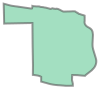

In [213]:
# Remove the remaining O'Hare tract. Conveniently, it's the westmost tract!
# Longitude (x):  (-) West <-> East (+)
westmost_tract_index = chicago_tracts.geometry.bounds["minx"].argmin()
chicago_tracts.iloc[westmost_tract_index].geometry

In [209]:
chicago_tracts = chicago_tracts.drop(chicago_tracts.index[westmost_tract_index])

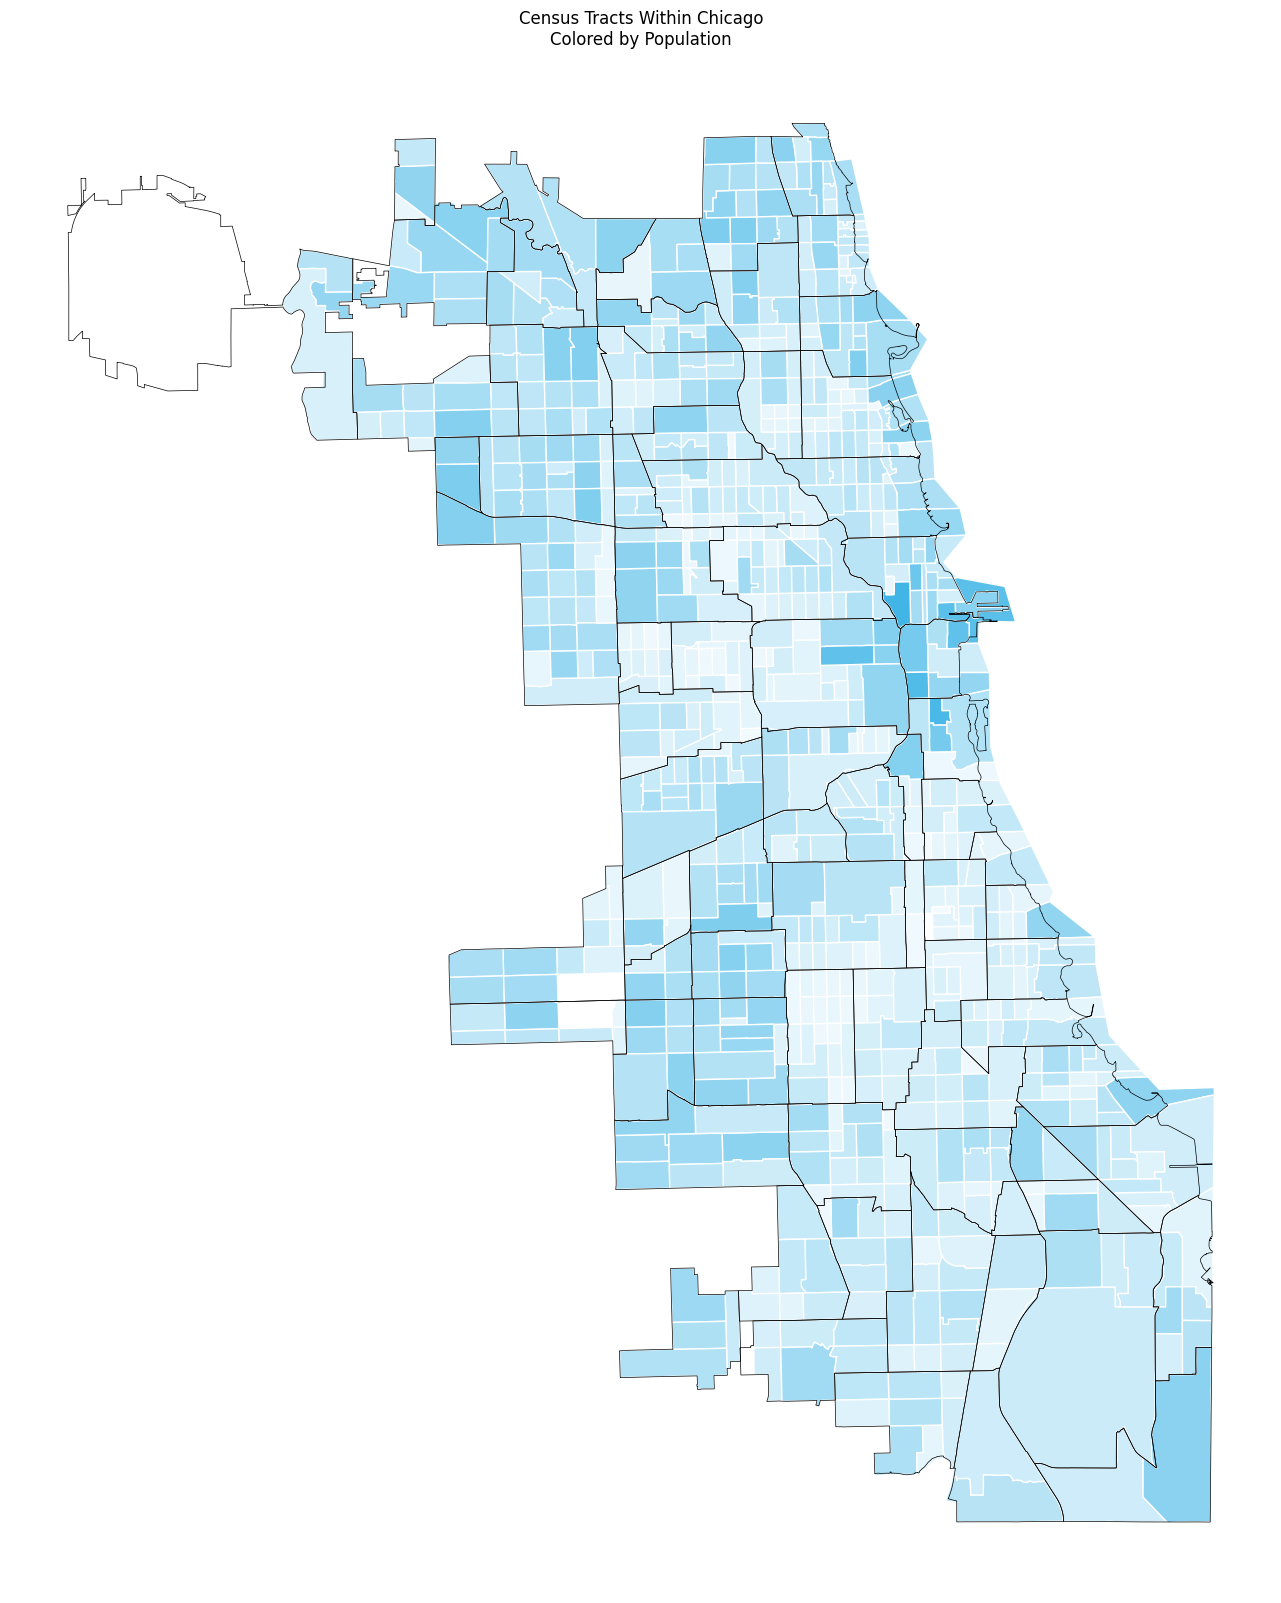

In [216]:
# Color map from white to Chicago flag blue
colors = ["#FFFFFF", COLORS["blue"]]
cmap = LinearSegmentedColormap.from_list("ChicagoBlues", colors)

ax = chicago_tracts.plot(column="Population", cmap=cmap, figsize=(20,20), edgecolor="#FFFFFF", linewidth=1)
CAs.geometry.plot(ax=ax, edgecolor="black", color=(0,0,0,0), linewidth=0.5)

ax.set_title("Census Tracts Within Chicago\nColored by Population")
ax.set_axis_off()
# plt.savefig("../plots/census_tracts_within_chicago_colored_by_population.png", dpi=300)

In [217]:
# chicago_tracts.to_pickle("../data/chicago_census_tracts_geodataframe.pkl")